Create a pipeline for the xml files, convert the entries to csv then move them to sqlite.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xmltodict as xd
import string
import re
from datetime import datetime

In [2]:
# #open and convert the xml to csv
# with open('data/mochada_mpesa.xml', 'r') as file:
#     data = xd.parse(file.read())


# #extracting the messages
# messages = data['smses']['sms']

# #converting to dataframe
# df = pd.DataFrame(messages)


# #save as a csv(optional)
# df.to_csv('mochada_sms.csv', index=False)

# df.tail()

With our xml file now as a csv file, we can start data wrangling.

## Data Wrangling
Lets look at the columns of in our dataset, clean them if need be, and then move on to Exploratory Data Analysis, before training our algorithm.

In [3]:
#loading csv file
df = pd.read_csv('mochada_sms.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   @protocol        3080 non-null   int64  
 1   @address         3080 non-null   object 
 2   @date            3080 non-null   int64  
 3   @type            3080 non-null   int64  
 4   @subject         0 non-null      float64
 5   @body            3080 non-null   object 
 6   @toa             0 non-null      float64
 7   @sc_toa          0 non-null      float64
 8   @service_center  3080 non-null   int64  
 9   @read            3080 non-null   int64  
 10  @status          3080 non-null   int64  
 11  @locked          3080 non-null   int64  
 12  @date_sent       3080 non-null   int64  
 13  @sub_id          3080 non-null   int64  
 14  @readable_date   3080 non-null   object 
 15  @contact_name    3080 non-null   object 
dtypes: float64(3), int64(9), object(4)
memory usage: 385.1+ KB


In [4]:
df.head(2)

,@protocol,@address,@date,@type,@subject,@body,@toa,@sc_toa,@service_center,@read,@status,@locked,@date_sent,@sub_id,@readable_date,@contact_name
0,0,MPESA,1713512313950,1,NaN,SDJ7N53FS3 Confirmed. On 19/4/24 at 10:38 AM T...,NaN,NaN,254722500040,1,-1,0,1713512297000,2,"Apr 19, 2024 10:38:33 AM",(Unknown)
1,0,MPESA,1713512587737,1,NaN,SDJ9N5M21L Confirmed. On 19/4/24 at 10:42 AM T...,NaN,NaN,254722500040,1,-1,0,1713512571000,2,"Apr 19, 2024 10:43:07 AM",(Unknown)


Based on the output from the last cell, here is a general outline of what we will do:
- Create a new dataframe with only three main columns; Address, Body, and readable date
- Change readable date to pandas datetime object
- Inspect and see what information to extract from the body ie balance amount, amount taken or given
- Perform a weekly analysis from Wednesday to Tuesday
- Calculate the monthly commission earned based on the transactions
- Do a time series analysis of the dataset

In [5]:
#columns to keep
keep = ['@address', '@body', '@readable_date']

#new data frame 
data = df[keep].copy()

#renaming the columns 
data.columns = ['address', 'body', 'date']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  3080 non-null   object
 1   body     3080 non-null   object
 2   date     3080 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [6]:
#converting the date into datetime object
data['date'] = pd.to_datetime(data['date'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   address  3080 non-null   object        
 1   body     3080 non-null   object        
 2   date     3080 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 72.3+ KB


In [7]:
data.tail()

,address,body,date
3075,MPESA,SGS245L5GQ Confirmed. On 28/7/24 at 10:55 AM T...,2024-07-28 10:55:57
3076,MPESA,SGS8488HBK Confirmed. on 28/7/24 at 11:20 AM G...,2024-07-28 11:20:05
3077,MPESA,SGS449HBC6 Confirmed. On 28/7/24 at 11:31 AM T...,2024-07-28 11:31:31
3078,MPESA,SGS949ZVIH Confirmed. On 28/7/24 at 11:35 AM T...,2024-07-28 11:36:22
3079,MPESA,SGS04DA44U Confirmed. On 28/7/24 at 12:05 PM T...,2024-07-28 12:05:47


With the new dataframe created, it seems most of the information is contained in the `body` column. Lets load one entry of this column and see what information is relevant to be extracted.

In [8]:
data['body'].iloc[4]

'SDJ4N12JZY Confirmed. On 19/4/24 at 10:03 AM Take Ksh300.00 cash from NICKSON MIDUNGA CHOGO Your M-PESA float balance is Ksh83,107.00. Click the link to Download M-Pesa Agent App and Transact the SMART way https://bit.ly/3Ll6JQU'

There is a unique `transaction ID` for each entry, then the status; `confirmed` or `failed`, transaction type; `take` or `give`, the `amount`, `name` of the customer and the `balance` remaining. 

Lets do some string manipulation.

In [9]:
transaction_id_pattern = r'^[A-Z0-9]{10}$'

#extract the first bit of each string to a new column
data['unique_id'] = data['body'].str.extract(r'^(\w+)')

#create a new column to validate the transaction codes
data['transaction_id'] = data['unique_id'].str.match(f'^{transaction_id_pattern}$')

data.tail(20)

,address,body,date,unique_id,transaction_id
3060,MPESA,Failed. Kindly capture the correct mobile numb...,2024-07-26 21:28:51,Failed,False
3061,MPESA,SGQ6Y1H018 Confirmed. On 26/7/24 at 9:29 PM Gi...,2024-07-26 21:29:33,SGQ6Y1H018,True
3062,MPESA,SGQ6Y1H018 Confirmed. On 26/7/24 at 9:29 PM Ta...,2024-07-26 21:29:43,SGQ6Y1H018,True
3063,MPESA,The customer is not registered to M-PESA and a...,2024-07-26 21:31:11,The,False
3064,MPESA,SGQ4Y1RXI6 Confirmed. On 26/7/24 at 9:31 PM Ta...,2024-07-26 21:32:02,SGQ4Y1RXI6,True
3065,MPESA,SGQ6Y1YOHQ Confirmed. Ksh400.00 sent to Equity...,2024-07-26 21:33:31,SGQ6Y1YOHQ,True
3066,MPESA,SGR12163XV Confirmed. Ksh100.00 sent to CLAIRE...,2024-07-27 18:24:19,SGR12163XV,True
3067,MPESA,SGS83T5DGW Confirmed. On 28/7/24 at 8:58 AM Ta...,2024-07-28 08:59:11,SGS83T5DGW,True
3068,MPESA,SGS43U9NDQ Confirmed. On 28/7/24 at 9:10 AM Ta...,2024-07-28 09:10:15,SGS43U9NDQ,True
3069,MPESA,SGS03XREVC Confirmed. On 28/7/24 at 9:43 AM Ta...,2024-07-28 09:43:46,SGS03XREVC,True


In [10]:

#lets separate valid transactions from other messages
valid_transactions = data[data['transaction_id']].copy()
others = data[~data['transaction_id']].copy()

valid_transactions['transaction_id'].unique()

array([ True])

In [11]:
valid_transactions.head()

,address,body,date,unique_id,transaction_id
0,MPESA,SDJ7N53FS3 Confirmed. On 19/4/24 at 10:38 AM T...,2024-04-19 10:38:33,SDJ7N53FS3,True
1,MPESA,SDJ9N5M21L Confirmed. On 19/4/24 at 10:42 AM T...,2024-04-19 10:43:07,SDJ9N5M21L,True
2,MPESA,SDJ9MU5DIL Confirmed. On 19/4/24 at 8:57 AM Ta...,2024-04-19 10:43:09,SDJ9MU5DIL,True
3,MPESA,SDJ2MYL302 Confirmed. On 19/4/24 at 9:39 AM Ta...,2024-04-19 10:43:10,SDJ2MYL302,True
4,MPESA,SDJ4N12JZY Confirmed. On 19/4/24 at 10:03 AM T...,2024-04-19 10:43:13,SDJ4N12JZY,True


In [12]:
others['transaction_id'].unique()

array([False])

In [13]:
others.head()

,address,body,date,unique_id,transaction_id
11,MPESA,Failed. Kindly capture the correct mobile numb...,2024-04-19 13:08:40,Failed,False
58,MPESA,Failed. Kindly capture the correct mobile numb...,2024-04-21 15:01:53,Failed,False
62,MPESA,Failed. Kindly capture the correct mobile numb...,2024-04-21 15:20:40,Failed,False
69,MPESA,Failed. Kindly capture the correct mobile numb...,2024-04-21 19:15:23,Failed,False
88,MPESA,Failed. Kindly capture the correct mobile numb...,2024-04-22 10:00:08,Failed,False


Lets move to extracting the `transaction type` and `amount transacted`.

In [14]:
data['body'].iloc[7]

'SDJ4NEIHH0 Confirmed. On 19/4/24 at 11:59 AM Take Ksh500.00 cash from CHRISTINE OKUKU Your M-PESA float balance is Ksh80,307.00. Click the link to Download M-Pesa Agent App and Transact the SMART way https://bit.ly/3Ll6JQU'

In [15]:
transaction_type_pattern = r'(Confirmed|Business\sDeposit\sConfirmed)'
compiled_pattern = re.compile(transaction_type_pattern, re.IGNORECASE)

#extract transaction type function
def extract_transaction_status(text):
    match = compiled_pattern.search(text)
    return match.group(0) if match else None

#apply function
valid_transactions['transaction_status_extracted'] = valid_transactions['body'].apply(extract_transaction_status)
valid_transactions['transaction_status_extracted'].unique()


array(['Confirmed', 'confirmed', 'Business Deposit Confirmed', None],
      dtype=object)

Now lets move to the `transaction type`.

In [16]:
action_pattern = r'(Take|Give|transferred from Working to Float)'

compiled_action = re.compile(action_pattern, re.IGNORECASE)

def extract_transaction_type(text):
    match = compiled_action.search(text)
    return match.group(0) if match else None

#applying the function
valid_transactions['transaction_type'] = valid_transactions['body'].apply(extract_transaction_type)
valid_transactions['transaction_type'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2871 entries, 0 to 3079
Series name: transaction_type
Non-Null Count  Dtype 
--------------  ----- 
2531 non-null   object
dtypes: object(1)
memory usage: 44.9+ KB


In [17]:
valid_transactions['transaction_type'].unique()

array(['Take', None, 'Give', 'transferred from Working to Float'],
      dtype=object)

In [18]:
valid_transactions = valid_transactions[valid_transactions['transaction_type'].notnull()].copy()
valid_transactions.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   address                       2531 non-null   object        
 1   body                          2531 non-null   object        
 2   date                          2531 non-null   datetime64[ns]
 3   unique_id                     2531 non-null   object        
 4   transaction_id                2531 non-null   bool          
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
dtypes: bool(1), datetime64[ns](1), object(5)
memory usage: 140.9+ KB


Done, lets get the `currency` and the `amount transacted`.

In [19]:
def extract_currency_amounts(text):
    # Regex pattern to find all occurrences of 'Ksh', 'KSh', or 'KES' followed by an amount
    pattern = r'(Ksh|KSh|KES)\s*([\d,]+\.\d{2})'
    
    # Find all matches
    matches = re.findall(pattern, text)
    
    if matches:
        # First match for transaction (currency and amount)
        transaction_currency, transaction_amount = matches[0]
        # Last match for balance (currency and amount)
        balance_currency, balance_amount = matches[-1]
    else:
        # If no match found, return None
        transaction_currency = transaction_amount = balance_currency = balance_amount = None
    
    return pd.Series([transaction_currency, transaction_amount, balance_currency, balance_amount])

valid_transactions[['transaction_currency', 'transaction_amount', 'balance_currency', 'balance_amount']] = valid_transactions['body'].apply(extract_currency_amounts)

valid_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   address                       2531 non-null   object        
 1   body                          2531 non-null   object        
 2   date                          2531 non-null   datetime64[ns]
 3   unique_id                     2531 non-null   object        
 4   transaction_id                2531 non-null   bool          
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
 7   transaction_currency          2531 non-null   object        
 8   transaction_amount            2531 non-null   object        
 9   balance_currency              2531 non-null   object        
 10  balance_amount                2531 non-null   object        
dtypes: bool(1), datetime64[ns](1),

In [20]:
#standardizing the datatypes for the columns
def convert(amount):
    if pd.isna(amount):
        return None
    return float(amount.replace(',', ''))

valid_transactions['balance_amount'] = valid_transactions['balance_amount'].apply(convert)
valid_transactions['transaction_amount'] = valid_transactions['transaction_amount'].apply(convert)

valid_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   address                       2531 non-null   object        
 1   body                          2531 non-null   object        
 2   date                          2531 non-null   datetime64[ns]
 3   unique_id                     2531 non-null   object        
 4   transaction_id                2531 non-null   bool          
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
 7   transaction_currency          2531 non-null   object        
 8   transaction_amount            2531 non-null   float64       
 9   balance_currency              2531 non-null   object        
 10  balance_amount                2531 non-null   float64       
dtypes: bool(1), datetime64[ns](1),

In [21]:
#lets move to extracting the customer's names
valid_transactions['body'].iloc[4]

'SDJ4N12JZY Confirmed. On 19/4/24 at 10:03 AM Take Ksh300.00 cash from NICKSON MIDUNGA CHOGO Your M-PESA float balance is Ksh83,107.00. Click the link to Download M-Pesa Agent App and Transact the SMART way https://bit.ly/3Ll6JQU'

In [22]:
#lets extract customer names
def extract_names(text):
    names_pattern = r'(?:from|to)\s([A-Za-z\s]+)\s(?:Your|New)'
    match = re.search(names_pattern, text)

    if match:
        return match.group(1).upper()
    else:
        return 'working balance'
    

valid_transactions['names'] = valid_transactions['body'].apply(extract_names)
valid_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   address                       2531 non-null   object        
 1   body                          2531 non-null   object        
 2   date                          2531 non-null   datetime64[ns]
 3   unique_id                     2531 non-null   object        
 4   transaction_id                2531 non-null   bool          
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
 7   transaction_currency          2531 non-null   object        
 8   transaction_amount            2531 non-null   float64       
 9   balance_currency              2531 non-null   object        
 10  balance_amount                2531 non-null   float64       
 11  names                         

In [23]:
valid_transactions

,address,body,date,unique_id,transaction_id,transaction_status_extracted,transaction_type,transaction_currency,transaction_amount,balance_currency,balance_amount,names
0,MPESA,SDJ7N53FS3 Confirmed. On 19/4/24 at 10:38 AM T...,2024-04-19 10:38:33,SDJ7N53FS3,True,Confirmed,Take,Ksh,1100.0,Ksh,82007.0,ROBERT MAHINDA
1,MPESA,SDJ9N5M21L Confirmed. On 19/4/24 at 10:42 AM T...,2024-04-19 10:43:07,SDJ9N5M21L,True,Confirmed,Take,Ksh,1100.0,Ksh,80907.0,BRIAN CHACHA
2,MPESA,SDJ9MU5DIL Confirmed. On 19/4/24 at 8:57 AM Ta...,2024-04-19 10:43:09,SDJ9MU5DIL,True,Confirmed,Take,Ksh,1100.0,Ksh,97007.0,CHRISTOPHER RWARA
3,MPESA,SDJ2MYL302 Confirmed. On 19/4/24 at 9:39 AM Ta...,2024-04-19 10:43:10,SDJ2MYL302,True,Confirmed,Take,Ksh,100.0,Ksh,83407.0,JOHN TIMPANKO
4,MPESA,SDJ4N12JZY Confirmed. On 19/4/24 at 10:03 AM T...,2024-04-19 10:43:13,SDJ4N12JZY,True,Confirmed,Take,Ksh,300.0,Ksh,83107.0,NICKSON MIDUNGA CHOGO
...,...,...,...,...,...,...,...,...,...,...,...,...
3075,MPESA,SGS245L5GQ Confirmed. On 28/7/24 at 10:55 AM T...,2024-07-28 10:55:57,SGS245L5GQ,True,Confirmed,Take,Ksh,100.0,Ksh,95611.0,VERONICA MUTUNGA
3076,MPESA,SGS8488HBK Confirmed. on 28/7/24 at 11:20 AM G...,2024-07-28 11:20:05,SGS8488HBK,True,Confirmed,Give,Ksh,100.0,Ksh,95711.0,WILLIAM KEIRO
3077,MPESA,SGS449HBC6 Confirmed. On 28/7/24 at 11:31 AM T...,2024-07-28 11:31:31,SGS449HBC6,True,Confirmed,Take,Ksh,500.0,Ksh,95211.0,JUDITH ODWORI
3078,MPESA,SGS949ZVIH Confirmed. On 28/7/24 at 11:35 AM T...,2024-07-28 11:36:22,SGS949ZVIH,True,Confirmed,Take,Ksh,250.0,Ksh,94961.0,DYNAH WAMBUGU


In [24]:
def extract_date(text):
    # Regex pattern to capture the date in DD/MM/YY format
    date_pattern = r'(\d{1,2}/\d{1,2}/\d{2})'
    
    # Search for the pattern
    match = re.search(date_pattern, text)
    
    if match:
        # Return the captured date
        return match.group(1)
    else:
        return None

# Function to extract the time from the text
def extract_time(text):
    # Regex pattern to capture the time (HH:MM AM/PM format)
    time_pattern = r'(\d{1,2}:\d{2}\s[APM]{2})'
    
    # Search for the pattern
    match = re.search(time_pattern, text)
    
    if match:
        # Return the captured time
        return match.group(1)
    else:
        return None

# Apply the functions to create new columns
valid_transactions['other_date'] = valid_transactions['body'].apply(extract_date)
valid_transactions['time'] = valid_transactions['body'].apply(extract_time)
valid_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   address                       2531 non-null   object        
 1   body                          2531 non-null   object        
 2   date                          2531 non-null   datetime64[ns]
 3   unique_id                     2531 non-null   object        
 4   transaction_id                2531 non-null   bool          
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
 7   transaction_currency          2531 non-null   object        
 8   transaction_amount            2531 non-null   float64       
 9   balance_currency              2531 non-null   object        
 10  balance_amount                2531 non-null   float64       
 11  names                         

In [25]:
valid_transactions.head()

,address,body,date,unique_id,transaction_id,transaction_status_extracted,transaction_type,transaction_currency,transaction_amount,balance_currency,balance_amount,names,other_date,time
0,MPESA,SDJ7N53FS3 Confirmed. On 19/4/24 at 10:38 AM T...,2024-04-19 10:38:33,SDJ7N53FS3,True,Confirmed,Take,Ksh,1100.0,Ksh,82007.0,ROBERT MAHINDA,19/4/24,10:38 AM
1,MPESA,SDJ9N5M21L Confirmed. On 19/4/24 at 10:42 AM T...,2024-04-19 10:43:07,SDJ9N5M21L,True,Confirmed,Take,Ksh,1100.0,Ksh,80907.0,BRIAN CHACHA,19/4/24,10:42 AM
2,MPESA,SDJ9MU5DIL Confirmed. On 19/4/24 at 8:57 AM Ta...,2024-04-19 10:43:09,SDJ9MU5DIL,True,Confirmed,Take,Ksh,1100.0,Ksh,97007.0,CHRISTOPHER RWARA,19/4/24,8:57 AM
3,MPESA,SDJ2MYL302 Confirmed. On 19/4/24 at 9:39 AM Ta...,2024-04-19 10:43:10,SDJ2MYL302,True,Confirmed,Take,Ksh,100.0,Ksh,83407.0,JOHN TIMPANKO,19/4/24,9:39 AM
4,MPESA,SDJ4N12JZY Confirmed. On 19/4/24 at 10:03 AM T...,2024-04-19 10:43:13,SDJ4N12JZY,True,Confirmed,Take,Ksh,300.0,Ksh,83107.0,NICKSON MIDUNGA CHOGO,19/4/24,10:03 AM


We are done cleaning the dataset, so lets move to visuals and we'll drop the unnecessary columns during modelling if need be.

## Univariate Analysis
Lets look at the distributions of different columns.

In [26]:
valid_transactions['body'].iloc[71]

'SDL3WG59Y7 Confirmed. On 21/4/24 at 10:12 PM Take Ksh297.00 cash from Olivia Kilonzo Your M-PESA float balance is Ksh12,321.00. Click the link to Download M-Pesa Agent App and Transact the SMART way https://bit.ly/3Ll6JQU'

In [57]:
columns_to_keep = [
    'date',
    'time',
    'other_date',
    'address',
    'unique_id',
    'transaction_status_extracted',
    'transaction_type',
    'names',
    'transaction_currency',
    'transaction_amount',
    'balance_currency',
    'balance_amount'
]

# v = valid_transactions[columns_to_keep].head()
# print(v)
model_df = valid_transactions[columns_to_keep]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          2531 non-null   datetime64[ns]
 1   time                          2531 non-null   object        
 2   other_date                    2531 non-null   object        
 3   address                       2531 non-null   object        
 4   unique_id                     2531 non-null   object        
 5   transaction_status_extracted  2531 non-null   object        
 6   transaction_type              2531 non-null   object        
 7   names                         2531 non-null   object        
 8   transaction_currency          2531 non-null   object        
 9   transaction_amount            2531 non-null   float64       
 10  balance_currency              2531 non-null   object        
 11  balance_amount                

In [58]:
renaming = {
    'address':'sender',
    'unique_id':'id',
    'transaction_status_extracted':'status',
    'transaction_type':'type',
    'transaction_currency':'currency',
    'transaction_amount':'transaction_amount',
    'balance_currency':'currency',
    'balance_amount':'balance',
    'names':'customer_id',
    'other_date':'date2'
}

model_df = model_df.rename(columns=renaming).copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2531 non-null   datetime64[ns]
 1   time                2531 non-null   object        
 2   date2               2531 non-null   object        
 3   sender              2531 non-null   object        
 4   id                  2531 non-null   object        
 5   status              2531 non-null   object        
 6   type                2531 non-null   object        
 7   customer_id         2531 non-null   object        
 8   currency            2531 non-null   object        
 9   transaction_amount  2531 non-null   float64       
 10  currency            2531 non-null   object        
 11  balance             2531 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 321.6+ KB


<Axes: title={'center': 'Distribution of Transaction Types'}>

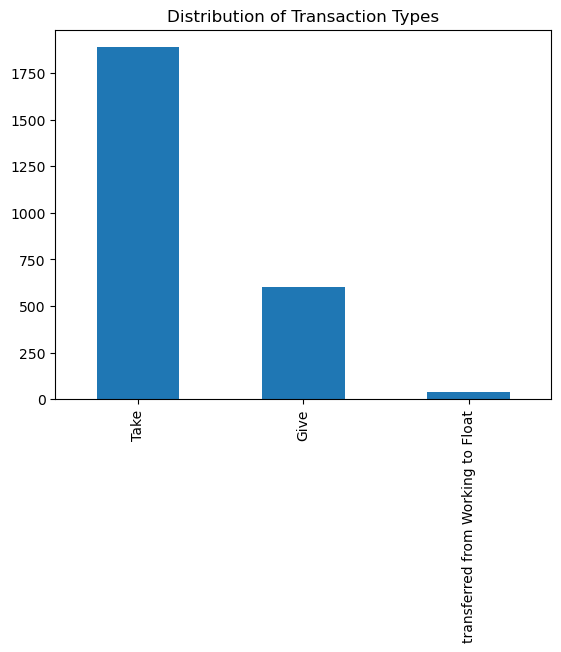

In [51]:
#lets begin with visualization of the transaction types

type_count = model_df['type'].value_counts()

type_count.plot(kind='bar', title='Distribution of Transaction Types')

It seems that there are significantly more deposits than withdrawals as represented by `take` and `give` respectively.

<Axes: title={'center': 'Transactions Per Day'}, xlabel='date'>

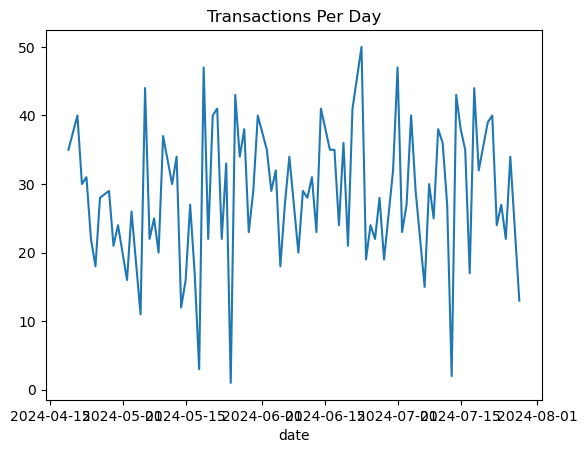

In [60]:
#line chart for transactions per day
model_df['date2'] = pd.to_datetime(model_df['date2'])


model_df['date'].groupby(model_df['date'].dt.date).size().plot(kind='line', title='Transactions Per Day')

<Axes: title={'center': 'Transactions Per Day'}, xlabel='time'>

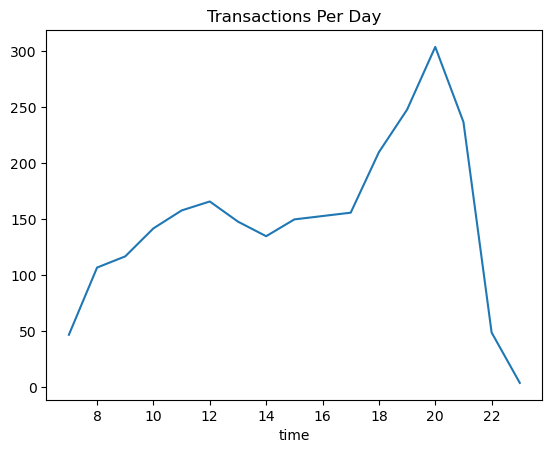

In [61]:
model_df['time'] = pd.to_datetime(model_df['time'])

model_df['time'].groupby(model_df['time'].dt.hour).size().plot(kind='line', title='Transactions Per Day')

<Axes: title={'center': 'Transaction Volume In a day'}, xlabel='time_of_day'>

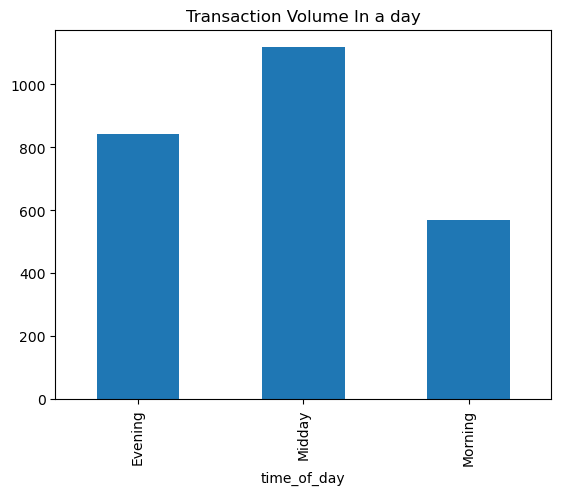

In [62]:
model_df['hour'] = model_df['time'].dt.hour

def get_time(hour):
    if 6 <= hour <12:
        return 'Morning'
    elif 12 <= hour <= 18:
        return 'Midday'
    elif 18 <= hour <= 24:
        return 'Evening'
    else:
        return 'Night'
    

model_df['time_of_day'] = model_df['hour'].apply(get_time)

transactions_time_of_day = model_df.groupby('time_of_day').size()

transactions_time_of_day.plot(kind = 'bar', title='Transaction Volume In a day')

It seems most of the transactions happen from `12pm` to `6pm`

<Axes: title={'center': 'Monthly Transactions'}, xlabel='month'>

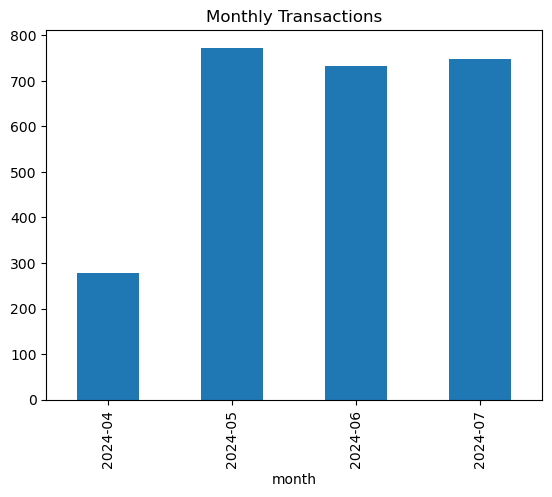

In [70]:
model_df['month'] = model_df['date'].dt.to_period('M')

transactions_per_month = model_df.groupby('month').size()

transactions_per_month.plot(kind='bar', title='Monthly Transactions')

In [64]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 3079
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2531 non-null   datetime64[ns]
 1   time                2531 non-null   datetime64[ns]
 2   date2               2531 non-null   datetime64[ns]
 3   sender              2531 non-null   object        
 4   id                  2531 non-null   object        
 5   status              2531 non-null   object        
 6   type                2531 non-null   object        
 7   customer_id         2531 non-null   object        
 8   currency            2531 non-null   object        
 9   transaction_amount  2531 non-null   float64       
 10  currency            2531 non-null   object        
 11  balance             2531 non-null   float64       
 12  hour                2531 non-null   int64         
 13  time_of_day         2531 non-null   object      

## Bivariate Analysis
How do these columns relate to each other?
Lets find that out by creating visuals of their pairs.

<Axes: title={'center': 'transaction_amount'}, ylabel='type'>

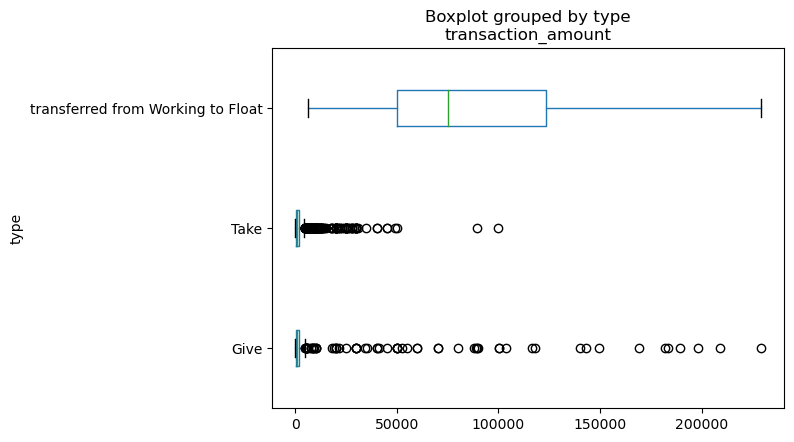

In [66]:
#lets start with a boxplot for the transaction amounts and types
model_df.boxplot(column='transaction_amount', by='type', grid=False, vert= False)

Not the best of visuals but it shows so many outliers meaning there is no consistency in the amount transacted.

<Axes: title={'center': 'Transaction amount Over Time'}, xlabel='hour', ylabel='transaction_amount'>

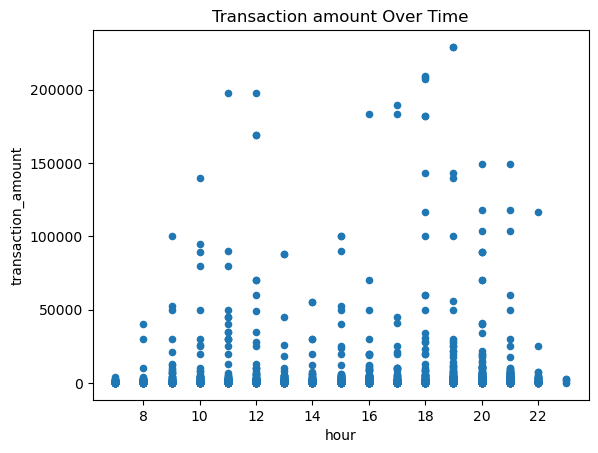

In [76]:
#lets look at the hour of the day vs amount
model_df.plot.scatter(x='hour', y='transaction_amount',title='Transaction amount Over Time')

<Axes: xlabel='time', ylabel='type'>

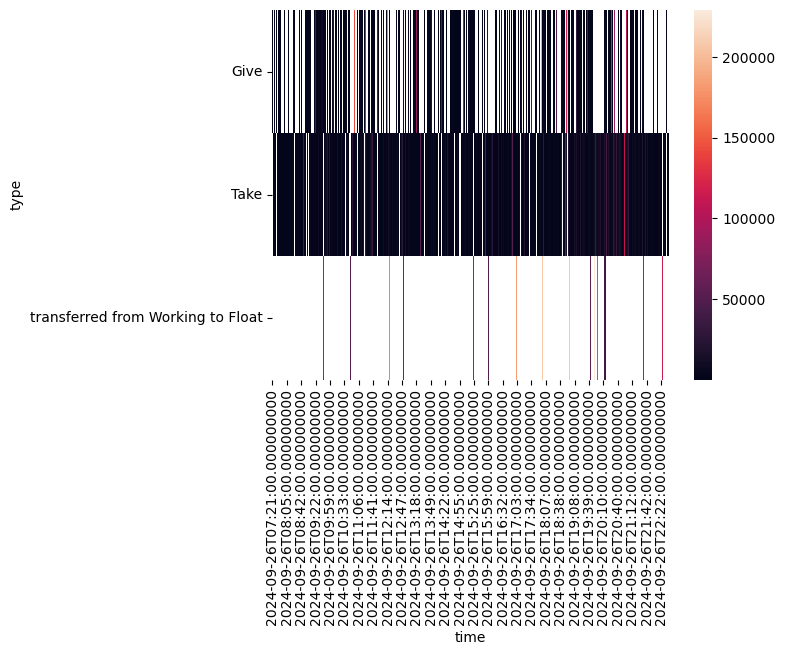

In [78]:
sns.heatmap(model_df.pivot_table(index='type', columns='time', values='transaction_amount', aggfunc='sum'))